In [1]:
import os
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [2]:
script_dir = os.path.dirname(Path().resolve())
os.chdir(script_dir)
os.makedirs(os.path.join(script_dir, 'output'), exist_ok=True)

In [3]:
st_df = pd.read_csv(os.path.join('output', 'sentence-transformers_results.csv'))

In [4]:
filtered_st_df = st_df.groupby(['top_k']).agg({'precision_scores': 'mean', 'recall_scores': 'mean'}).reset_index()
filtered_st_df

,top_k,precision_scores,recall_scores
0,10,0.017549,0.946850
1,5,0.030675,0.852251
2,Min,0.083078,0.565784


The top_k parameter demonstrates a classic precision-recall tradeoff.
As we retrieve more documents, we increase chance of obtaining relevant information (high recall) but that way we delute precision.

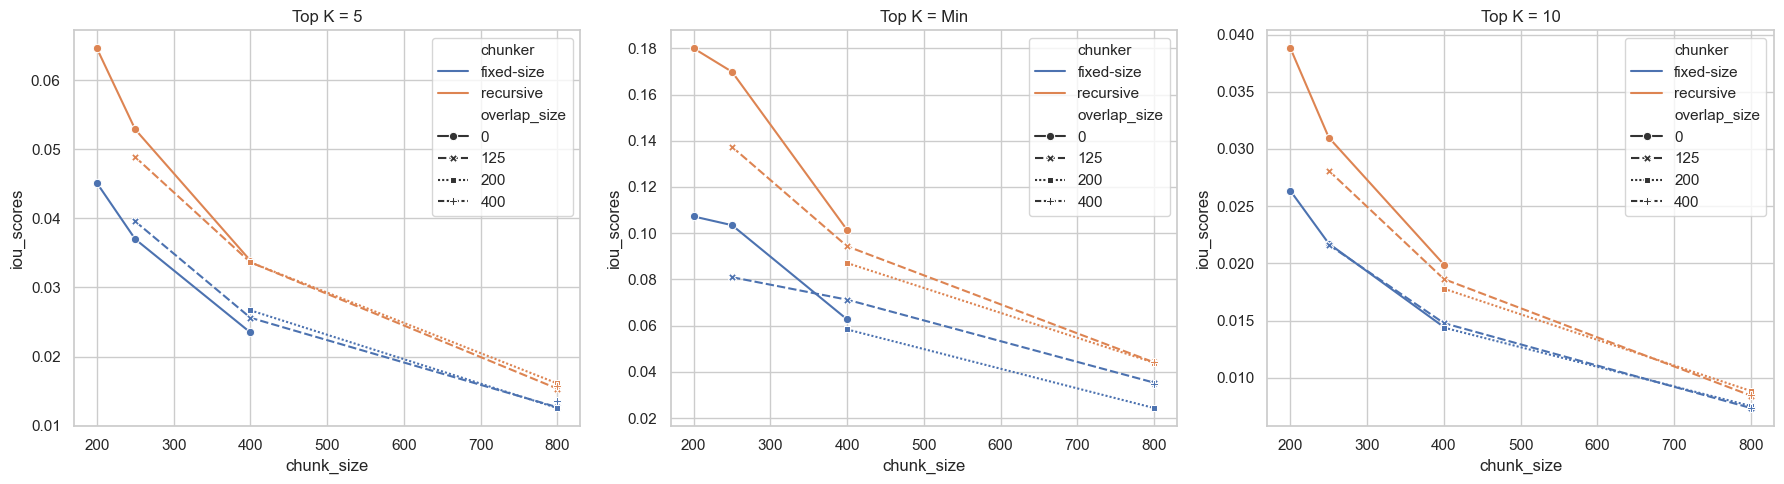

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# For top_k = 5
sns.lineplot(
    data=st_df[st_df['top_k'] == '5'],
    x='chunk_size',
    y='iou_scores',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax1
)
ax1.set_title('Top K = 5')

# For top_k = Min
sns.lineplot(
    data=st_df[st_df['top_k'] == 'Min'],
    x='chunk_size',
    y='iou_scores',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax2
)
ax2.set_title('Top K = Min')

# For top_k = 10
sns.lineplot(
    data=st_df[st_df['top_k'] == '10'],
    x='chunk_size',
    y='iou_scores',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax3
)
ax3.set_title('Top K = 10')

plt.tight_layout()

We can take the mean iou_score for every chunk_size and visualize it better.

<Axes: xlabel='chunk_size', ylabel='iou_scores'>

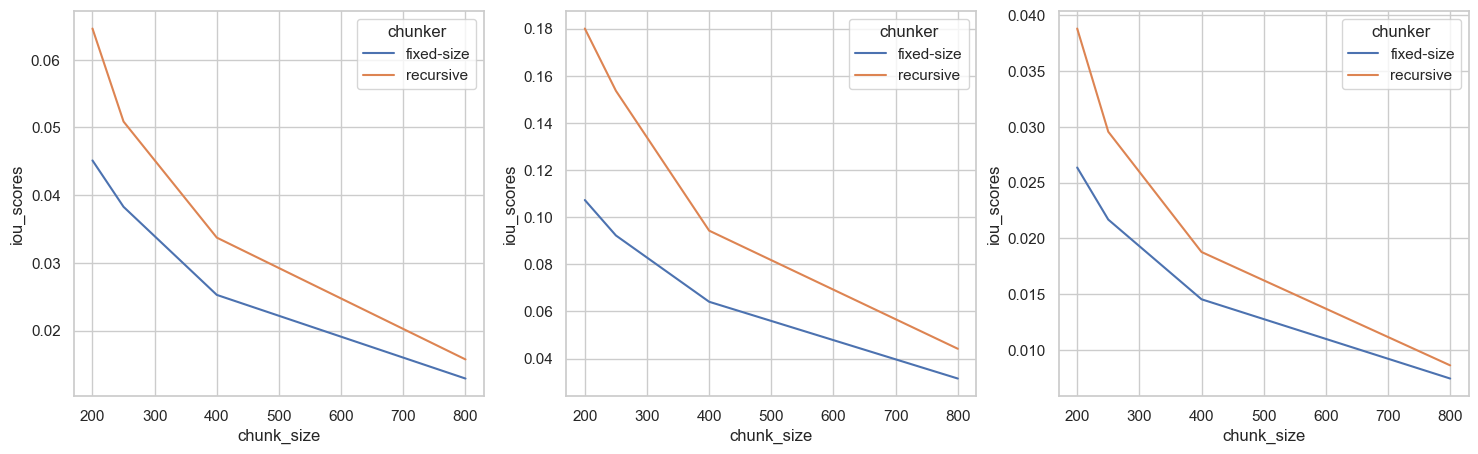

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
filtered_st_df = st_df.groupby(['chunker', 'chunk_size', 'top_k']).agg({'iou_scores': 'mean'}).reset_index()
sns.lineplot(data=filtered_st_df[filtered_st_df['top_k'] == '5'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax1)
sns.lineplot(data=filtered_st_df[filtered_st_df['top_k'] == 'Min'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax2)
sns.lineplot(data=filtered_st_df[filtered_st_df['top_k'] == '10'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax3)

As we can observe, iou_score decreases with increasing chunk_size

For example, let's take top_k=5:
At chunk_size=200: recursive chunker achieves 0.065 IOU
At chunk_size=800: similar configurations achieve only ~0.016 IOU
That's approx. 75% reduction in IoU.

When chunk_size is big, each chunk contains more tokens, possibly leading to much more noise (irrelevant tokens).
Therefore, IoU score's denominator increases gradually.

Without loss of generality, let's set overlap_size=0 and compare the performance of the two chunkers.

<Axes: xlabel='chunk_size', ylabel='iou_scores'>

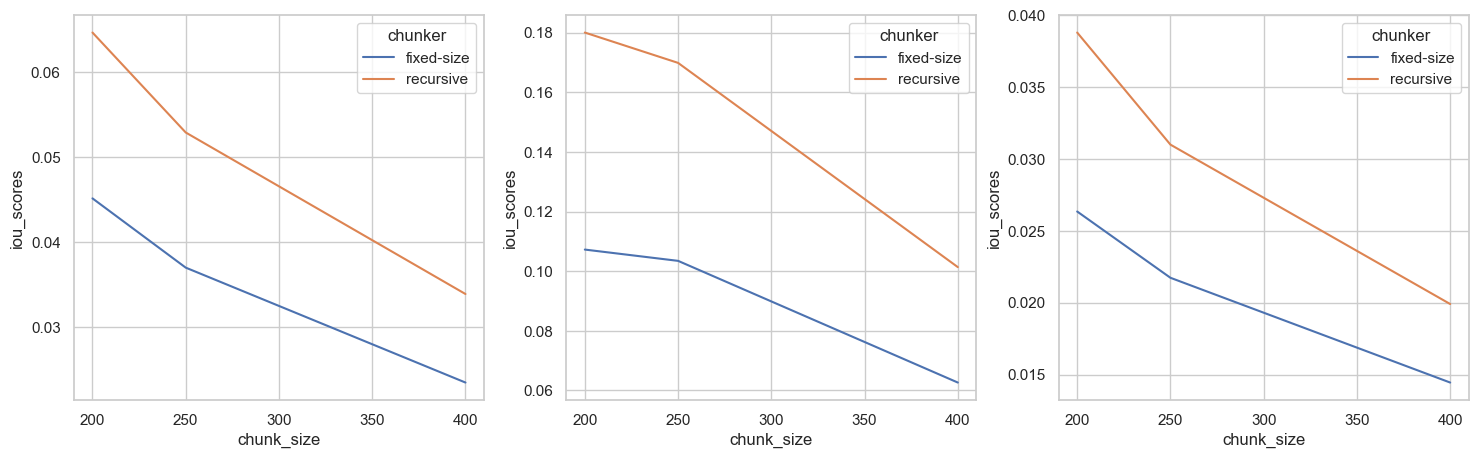

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
filtered_gpt_df = st_df[st_df['overlap_size'] == 0]
filtered_gpt_df = filtered_gpt_df.groupby(['chunker', 'chunk_size', 'top_k']).agg({'iou_scores': 'mean'}).reset_index()
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == '5'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax1)
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == 'Min'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax2)
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == '10'], x='chunk_size', y='iou_scores', hue='chunker', ax=ax3)

Recursive chunking consistently outperforms fixed-size chunking across almost all configurations.


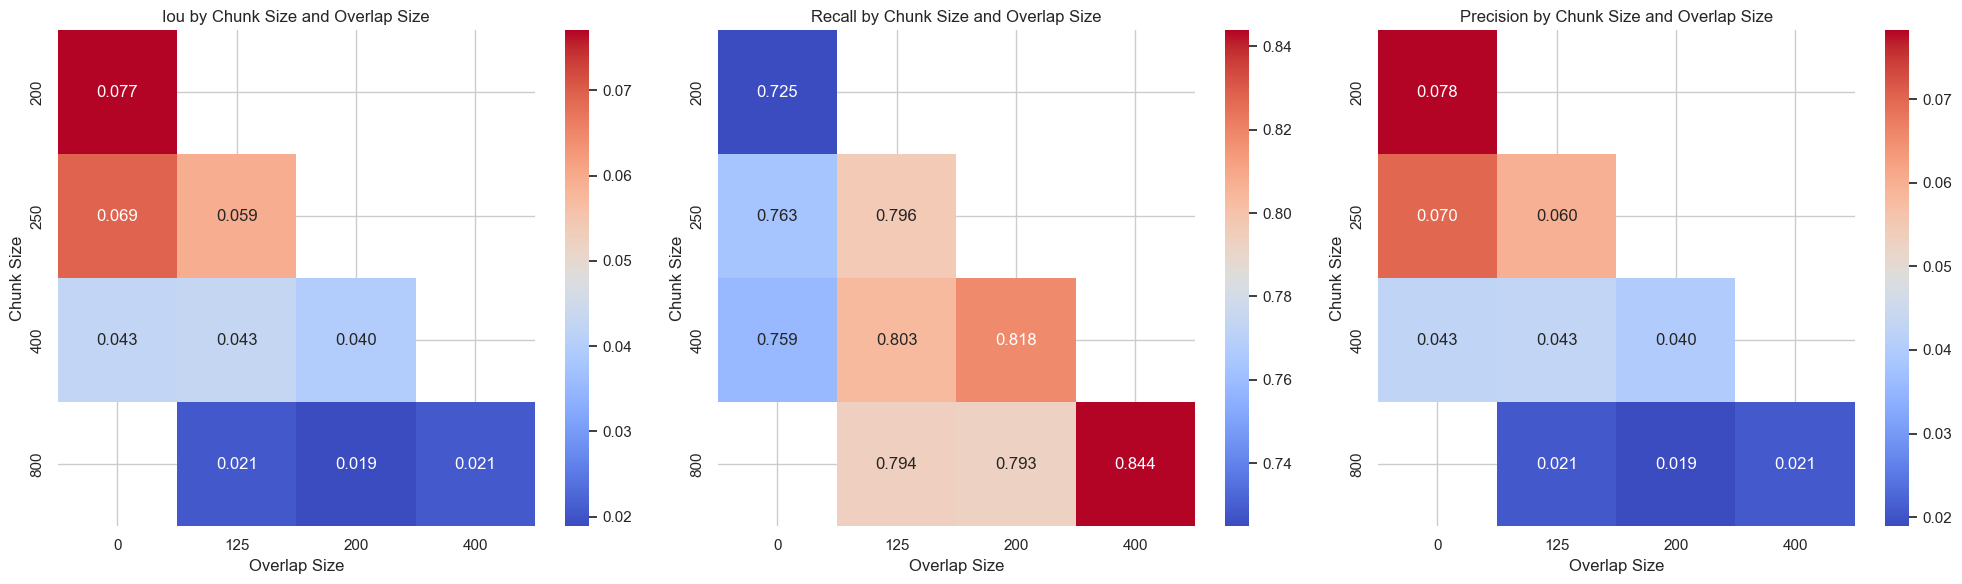

In [8]:
def plot_all_metrics_heatmap(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    metrics = ['iou', 'recall', 'precision']
    axes = [ax1, ax2, ax3]
    
    for metric, ax in zip(metrics, axes):
        pivot_df = df.pivot_table(
            values=f'{metric}_scores',
            index='chunk_size',
            columns='overlap_size',
            aggfunc='mean'
        )
        sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap='coolwarm', ax=ax)
        ax.set_title(f'{metric.capitalize()} by Chunk Size and Overlap Size')
        ax.set_xlabel('Overlap Size')
        ax.set_ylabel('Chunk Size')
    
    plt.tight_layout()
    
plot_all_metrics_heatmap(st_df)

Let's extract the maximum values of recall, iou, and precision for each top_k configuration.

In [9]:
def max_values(df):
    max_recall = df.loc[df['recall_scores'].idxmax()]
    max_iou = df.loc[df['iou_scores'].idxmax()]
    max_precision = df.loc[df['precision_scores'].idxmax()]
    
    return max_recall, max_iou, max_precision

In [10]:
st_max_all = pd.DataFrame()

for k in ['5', '10', 'Min']:
    df = st_df[st_df['top_k'] == k]
    max_st_recall, max_st_iou, max_st_precision = max_values(df)
    
    st_max = pd.DataFrame([max_st_recall, max_st_iou, max_st_precision], 
                          index=['max-recall', 'max-iou', 'max-precision'])
    
    st_max_all = pd.concat([st_max_all, st_max], axis=0)
    
st_max_all

,chunker,chunk_size,overlap_size,top_k,iou_scores,recall_scores,precision_scores
max-recall,recursive,800,200,5,0.016111,0.934239,0.016111
max-iou,recursive,200,0,5,0.064607,0.778386,0.064940
max-precision,recursive,200,0,5,0.064607,0.778386,0.064940
max-recall,recursive,800,200,10,0.008855,0.993056,0.008855
max-iou,recursive,200,0,10,0.038795,0.883052,0.038848
max-precision,recursive,200,0,10,0.038795,0.883052,0.038848
max-recall,fixed-size,800,400,Min,0.034888,0.699084,0.035021
max-iou,recursive,200,0,Min,0.179994,0.510153,0.184537
max-precision,recursive,200,0,Min,0.179994,0.510153,0.184537


We can conduct few interesting configurations of hyperparameters:

#### Highest IoU/Precision Configuration
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: Min

#### Highest Recall Configuration
- Chunker: Recursive
- Chunk Size: 800
- Overlap Size: 200
- Top K: 10

#### Overall Well-Performing Configurations
##### Configuration 1
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: 5
##### Configuration 2
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: 10